In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings
import time

filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
)
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    cross_val_score,
    GridSearchCV,
    RandomizedSearchCV,
)

import xgboost as xgb

np.random.seed(42)
sns.set_style("whitegrid")

print("All imports successful! ✅")
print(f"XGBoost version: {xgb.__version__}")

All imports successful! ✅
XGBoost version: 3.1.1


## 1. Load Data and Separate Labeled/Unlabeled


In [2]:
# Load data
df = pd.read_csv("Analytica.csv")

print(f"Total samples: {len(df)}")
print(f"Labeled samples (non-NaN target): {df['target'].notna().sum()}")
print(f"Unlabeled samples (NaN target): {df['target'].isna().sum()}")

# Separate labeled and unlabeled data
df_labeled = df[df["target"].notna()].copy()
df_unlabeled = df[df["target"].isna()].copy()

print(f"\nLabeled data shape: {df_labeled.shape}")
print(f"Unlabeled data shape: {df_unlabeled.shape}")

Total samples: 34163
Labeled samples (non-NaN target): 5096
Unlabeled samples (NaN target): 29067

Labeled data shape: (5096, 112)
Unlabeled data shape: (29067, 112)


In [3]:
# Check class distribution in labeled data
print("Class distribution in labeled data:")
print(df_labeled["target"].value_counts())
print(f"\nClass balance: {df_labeled['target'].mean():.2%} are class 1")

Class distribution in labeled data:
target
0.0    2683
1.0    2413
Name: count, dtype: int64

Class balance: 47.35% are class 1


## 2. Prepare Features


In [4]:
# Extract features (exclude ID and target)
feature_cols = [col for col in df.columns if col not in ["ID", "target"]]
print(f"Number of features: {len(feature_cols)}")

# Prepare training data from labeled examples
X_train_full = df_labeled[feature_cols].values
y_train_full = df_labeled["target"].values.astype(int)

# Prepare test data (unlabeled examples to predict)
X_test = df_unlabeled[feature_cols].values
unlabeled_ids = df_unlabeled["ID"].values

print(f"Training data shape: {X_train_full.shape}")
print(f"Test data shape: {X_test.shape}")

Number of features: 110
Training data shape: (5096, 110)
Test data shape: (29067, 110)


In [5]:
# Scale features - fit on labeled data only
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_full)
X_test_scaled = scaler.transform(X_test)

print(
    f"Scaled training data - Mean: {X_train_scaled.mean():.4f}, Std: {X_train_scaled.std():.4f}"
)

Scaled training data - Mean: 0.0000, Std: 1.0000


## 3. Train/Validation Split


In [6]:
# Split labeled data for validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train_scaled, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")

Training set: 4076 samples
Validation set: 1020 samples


## 4. Hyperparameter Tuning with RandomizedSearchCV

This will take ~3-4 minutes to find optimal hyperparameters.


In [7]:
# Define hyperparameter search space
param_distributions = {
    "n_estimators": [200, 300, 500, 700, 1000],
    "max_depth": [3, 4, 5, 6, 7, 8, 10],
    "learning_rate": [0.01, 0.02, 0.05, 0.1, 0.15],
    "subsample": [0.6, 0.7, 0.8, 0.9, 1.0],
    "colsample_bytree": [0.6, 0.7, 0.8, 0.9, 1.0],
    "min_child_weight": [1, 2, 3, 5],
    "gamma": [0, 0.1, 0.2, 0.3],
    "reg_alpha": [0, 0.01, 0.1, 1],
    "reg_lambda": [1, 1.5, 2, 3],
}

# Base model
base_model = xgb.XGBClassifier(
    random_state=42, eval_metric="logloss", use_label_encoder=False, n_jobs=-1
)

# Cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Starting hyperparameter search...")
print("This may take 3-4 minutes.\n")

start_time = time.time()

# RandomizedSearchCV for faster search
random_search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_distributions,
    n_iter=50,  # Number of parameter settings sampled
    scoring="roc_auc",
    cv=cv,
    verbose=1,
    random_state=42,
    n_jobs=-1,
)

random_search.fit(X_train_scaled, y_train_full)

elapsed_time = time.time() - start_time
print(f"\nHyperparameter search completed in {elapsed_time/60:.2f} minutes")
print(f"\nBest ROC-AUC Score: {random_search.best_score_:.4f}")
print(f"\nBest Parameters:")
for param, value in random_search.best_params_.items():
    print(f"  {param}: {value}")

Starting hyperparameter search...
This may take 3-4 minutes.

Fitting 5 folds for each of 50 candidates, totalling 250 fits

Hyperparameter search completed in 2.59 minutes

Best ROC-AUC Score: 0.9185

Best Parameters:
  subsample: 1.0
  reg_lambda: 3
  reg_alpha: 0.1
  n_estimators: 1000
  min_child_weight: 2
  max_depth: 6
  learning_rate: 0.02
  gamma: 0.3
  colsample_bytree: 0.6


## 5. Train Final Model with Best Parameters


In [8]:
# Get best parameters and increase n_estimators for final model
best_params = random_search.best_params_.copy()

# Increase estimators for final training with early stopping
best_params["n_estimators"] = 1500

print("Training final model with extended estimators...")
start_time = time.time()

final_model = xgb.XGBClassifier(
    **best_params,
    random_state=42,
    eval_metric="logloss",
    use_label_encoder=False,
    early_stopping_rounds=50,
    n_jobs=-1,
)

# Train with early stopping on validation set
final_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

elapsed_time = time.time() - start_time
print(f"Final model trained in {elapsed_time:.2f} seconds")
print(f"Best iteration: {final_model.best_iteration}")

Training final model with extended estimators...
Final model trained in 2.23 seconds
Best iteration: 449


## 6. Evaluate Model


In [9]:
# Predictions on validation set
y_val_pred = final_model.predict(X_val)
y_val_proba = final_model.predict_proba(X_val)[:, 1]

# Metrics
accuracy = accuracy_score(y_val, y_val_pred)
roc_auc = roc_auc_score(y_val, y_val_proba)

print(f"Validation Accuracy: {accuracy:.4f}")
print(f"Validation ROC-AUC: {roc_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred))

Validation Accuracy: 0.8255
Validation ROC-AUC: 0.9129

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.85      0.84       537
           1       0.83      0.80      0.81       483

    accuracy                           0.83      1020
   macro avg       0.83      0.82      0.82      1020
weighted avg       0.83      0.83      0.83      1020



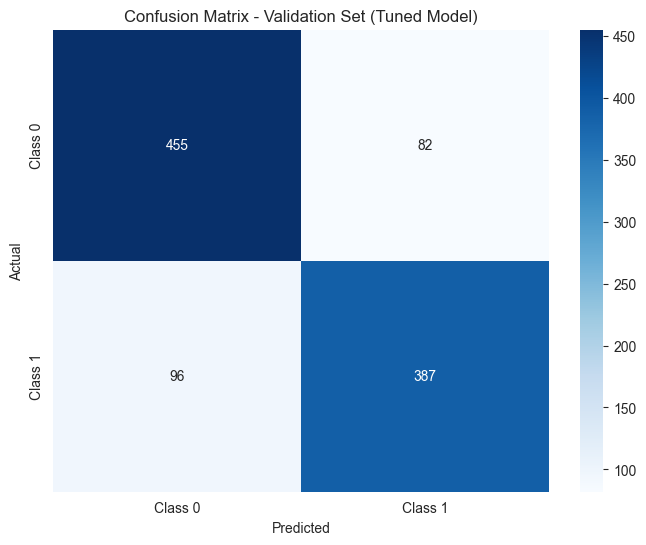

In [10]:
# Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Class 0", "Class 1"],
    yticklabels=["Class 0", "Class 1"],
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Validation Set (Tuned Model)")
plt.show()

## 7. Feature Importance


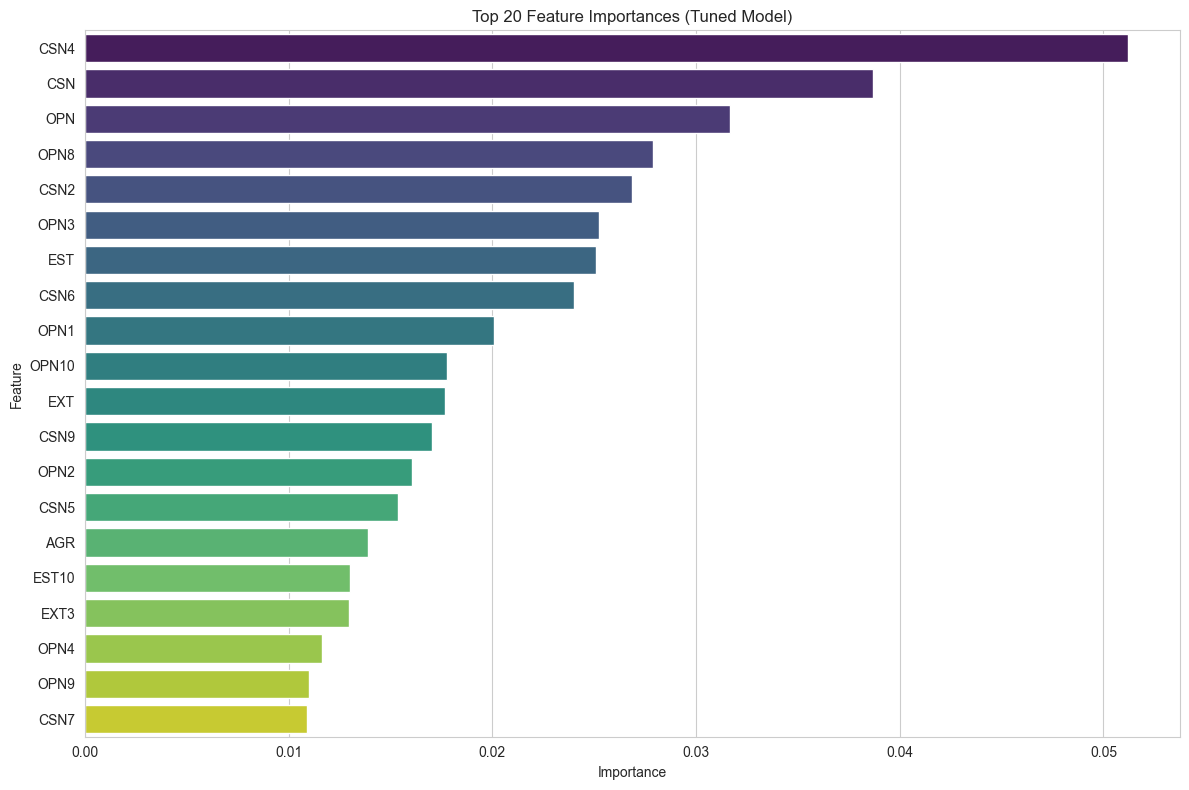

In [11]:
# Feature importance
importance = final_model.feature_importances_
feature_importance = pd.DataFrame(
    {"Feature": feature_cols, "Importance": importance}
).sort_values(by="Importance", ascending=False)

# Plot top 20 features
plt.figure(figsize=(12, 8))
sns.barplot(
    data=feature_importance.head(20), x="Importance", y="Feature", palette="viridis"
)
plt.title("Top 20 Feature Importances (Tuned Model)")
plt.tight_layout()
plt.show()

## 8. Retrain on Full Labeled Data


In [12]:
# Use best iteration from early stopping for final model
best_n_estimators = (
    final_model.best_iteration
    if final_model.best_iteration
    else best_params["n_estimators"]
)
best_params["n_estimators"] = best_n_estimators

print(
    f"Training production model with {best_n_estimators} estimators on all labeled data..."
)
start_time = time.time()

production_model = xgb.XGBClassifier(
    **best_params,
    random_state=42,
    eval_metric="logloss",
    use_label_encoder=False,
    n_jobs=-1,
)

production_model.fit(X_train_scaled, y_train_full, verbose=False)

elapsed_time = time.time() - start_time
print(f"Production model trained in {elapsed_time:.2f} seconds ✅")

Training production model with 449 estimators on all labeled data...
Production model trained in 1.75 seconds ✅


In [13]:
# Predict on unlabeled data
predictions = production_model.predict(X_test_scaled)
predictions_proba = production_model.predict_proba(X_test_scaled)[:, 1]

print(f"Predictions made: {len(predictions)}")
print(f"\nPredicted class distribution:")
print(pd.Series(predictions).value_counts())
print(f"\nPrediction probability stats:")
print(f"  Mean: {predictions_proba.mean():.4f}")
print(f"  Std:  {predictions_proba.std():.4f}")
print(f"  Min:  {predictions_proba.min():.4f}")
print(f"  Max:  {predictions_proba.max():.4f}")

Predictions made: 29067

Predicted class distribution:
0    15677
1    13390
Name: count, dtype: int64

Prediction probability stats:
  Mean: 0.4665
  Std:  0.3559
  Min:  0.0020
  Max:  0.9965


## 9. Create Submission File


In [14]:
# Create submission dataframe
submission = pd.DataFrame({"ID": unlabeled_ids, "prediction": predictions})

print("Submission preview:")
submission.head(10)

Submission preview:


,ID,prediction
0,20160303022202,1
1,20160303052049,1
2,20160303052319,0
3,20160303055318,0
4,20160303063505,1
5,20160303064930,1
6,20160303070035,1
7,20160303080108,1
8,20160303080415,1
9,20160303084611,1


In [15]:
# Save submission
submission.to_csv("submit_xgboost_tuned.csv", index=False)
print("Submission saved to submit_xgboost_tuned.csv ✅")
print(f"Total predictions: {len(submission)}")

Submission saved to submit_xgboost_tuned.csv ✅
Total predictions: 29067


## 10. Summary


In [16]:
print("=" * 50)
print("TRAINING SUMMARY")
print("=" * 50)
print(f"\nBest Hyperparameters Found:")
for param, value in random_search.best_params_.items():
    print(f"  {param}: {value}")
print(f"\nCross-Validation ROC-AUC: {random_search.best_score_:.4f}")
print(f"Validation ROC-AUC: {roc_auc:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")
print(f"\nPredictions saved to: submit_xgboost_tuned.csv")
print("=" * 50)

TRAINING SUMMARY

Best Hyperparameters Found:
  subsample: 1.0
  reg_lambda: 3
  reg_alpha: 0.1
  n_estimators: 1000
  min_child_weight: 2
  max_depth: 6
  learning_rate: 0.02
  gamma: 0.3
  colsample_bytree: 0.6

Cross-Validation ROC-AUC: 0.9185
Validation ROC-AUC: 0.9129
Validation Accuracy: 0.8255

Predictions saved to: submit_xgboost_tuned.csv
